BookTheSurprise is an ecommerce platform that generates 100% of their sales through their website. Lately, They have seen a dip in conversion, although the website traffic seems to be high.

After careful consideration, They have a new webpage designed & implemented with the intention to increase their conversion rates, it went from 23.33% in 2020 to 32.22% in 2021. With such an ambiguous task, they want to gain insights from the team whether the conversion rates have shot up due to new webite design or not. Unforunately they haven't built up a data science capability in their company, but they do have data from thier google analytics account. 

So,The goal of this notebook will serve as a primer into A/B testing. It has two main goals:

- This notebook will provide a statistical way to compare two versions of webpages, old webpage(using in 2020) and new webpage(using in 2021), to determine not only which one performs better but also to understand if the difference between two of them is statistically significant.
    
- The old conversion rate of 23.33% is chosen from the control data, and current conversion rate of 33.33% is chosen from the treatment data, in order to achieve the highest minimum Sample Size required.

In [1]:
#first, load packages:
import pandas as pd
import numpy as np
import scipy.stats as ss
import math as mt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df=pd.read_csv('/kaggle/input/analytics4/GA_final.csv')

In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55500 entries, 0 to 55499
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   fullVisitorId                  55500 non-null  int64  
 1   visitNumber                    55500 non-null  int64  
 2   date                           55500 non-null  object 
 3   Sessions                       55500 non-null  int64  
 4   Page_Views                     55500 non-null  int64  
 5   New_Visitors                   55500 non-null  int64  
 6   Hits                           55500 non-null  int64  
 7   Time_onsite(minutes)           55500 non-null  int64  
 8   bounces_offsite                55500 non-null  int64  
 9   Revenue(Rs/.)                  55500 non-null  float64
 10  Total_Revenues                 55500 non-null  float64
 11  is_direct                      55500 non-null  int64  
 12  is_mobile                      55500 non-null 

(55500, 19)

#### Add a column if conversion rate > 0 to binary classify whether converted or not.

In [4]:
df['is_converted']=df['Conversion_Rate(%age)'].apply(lambda x: 1 if x>0 else 0 )

In [6]:
#### Add year column

In [5]:
from datetime import datetime 
df['date']=pd.to_datetime(df['date'],errors='coerce')

In [6]:
df['year']=df['date'].dt.year

In [7]:
df['group']=''
df.loc[df['year']==2020,'group']= 'control'
df.loc[df['year']==2021,'group']= 'treatment'

In [8]:
df.loc[df['is_converted']==1,'year'].value_counts()

2021    148
2020     64
Name: year, dtype: int64

In [9]:
df.loc[df['is_converted']==0,'year'].value_counts()

2021    32702
2020    22586
Name: year, dtype: int64

## Power analysis

- To provide an analysis of an A/B-test, let calculate the conversion rates (number of purchases/number of visits) in our company. 

- To decide what is the minimum number of people we need to prove/reject the hypothesis, we have to conduct a power analysis.

In [10]:
old_conversion_rate=df.loc[df['year']==2020]['Conversion_Rate(%age)'].mean()
print(old_conversion_rate)

0.23384906856018983


In [11]:
new_conversion_rate= df.loc[df['year']==2021]['Conversion_Rate(%age)'].mean()
print(new_conversion_rate)

0.32213266648687633


We can see that our conversion rates on old webpage were 23.33%. On our new webpage our conversion rates has increased to 32.21%. Lets determine now the minimum effect size for this test to work

In [13]:
import statsmodels.stats.api as sms


effect_size = sms.proportion_effectsize(old_conversion_rate, new_conversion_rate)    # Calculating effect size based on our expected rates

required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.9,  #power of a test (defualt is 0.8)
    alpha=0.05, #p-value
    ratio=1
    )                                                  # Calculating sample size needed

required_n = np.ceil(required_n)                          # Rounding up to next whole number                          

print(required_n)

539.0


In [14]:
if (required_n< df[df['group']=='control'].group.count()) and (required_n< df[df['group']=='treatment'].group.count()) :
    print('The effect size of both the group is greater than the required minimum, so lets proceed')
    
else:
    print('cant continue')

The effect size of both the group is greater than the required minimum, so lets proceed


#### Count of converted users by group

In [15]:
import seaborn as sns

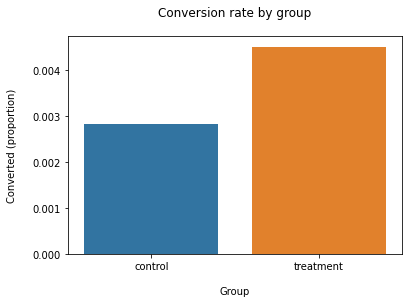

In [16]:
sns.barplot(x=df['group'], y=df['is_converted'], ci=False)

plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

<b><u>Probabilities:</u></b>

In [17]:
P_pool = (df.query('is_converted == 1').is_converted.count())/df.shape[0]
P_pool

0.00381981981981982

In [18]:
#total/pooled probability of conversion:
P_pool = (df.query('is_converted == 1').is_converted.count())/df.shape[0]
P_pool

0.00381981981981982

In [19]:
#probability of conversion given a user was in the control group:
control_df = df.query('group =="control"')
P_old = control_df['is_converted'].mean()
P_old

0.00282560706401766

In [20]:
#probability of conversion given a user was in the treatment group:
treatment_df = df.query('group =="treatment"')
P_new = treatment_df['is_converted'].mean()
P_new

0.004505327245053273

We can quickly observe that our new page is infact doing a better job at conversion improvement, than our old page.

So now we can proceed with more checks and measures we must do before and after an A/B test to ensure our experiment as run properly.

<b><u>1. Binomial Proportion Confidence Intervals:</u></b>

This method is quoted as the 'most common' method for A/B testing, where we find Confidence Intervals (CI) for both $P_{new}$ and $P_{old}$. If we construct similar intervals for both and compare them, we will end up in either scenario: (jkndrkn, 2012)

1. The Intervals do not overlap: This implies that we can say with some level of confidence that one is better than the other, therefore providing enough evidence to reject the Null Hypothesis. This level of confidence seems to be $≈ 1-e \alpha^{1.91}%$ (Lan, 2011). So if there is overlap and the 95% CI are the same size, the difference is significant at the 99.5% level.

2. The Intervals do overlap: Then it is either a sign that our population does not have enough statistical power, or we do not have enough evidence to reject the Null Hypothesis that $P_{new} = P_{old}$.

There is a relationship between CI comparisons and hypothesis tests - given that the sample sizes are not too different and the two sets have similar standard deviations. This method wouldn't derive highly precise p-values from comparing two CIs, but there is a good write up that tries to quantify this (Lan, 2011).

Finding the 'true' conversion rate of a particular group is usually impossible or difficult, but we can use our calculated $P_{new}$ and $P_{old}$ as point estimations to find the Confidence Intervals for the 'true' $P_{new}$ and $P_{old}$. A good explanation for beginners about using point intervals to calculate a CI for the 'true' conversion rate can be found in the Appendix of <i>"A/B Testing: The Most Powerful Way to Turn Clicks into Customers"</i> (Siroker & Koomen, 2013)

In [21]:
#function for getting z-scores for alpha. For our experiemnt where alpha = 5%, keep in mind we want to input 1-alpha/2 for Confidence Intervals.
def get_z_score(alpha):
    return ss.norm.ppf(alpha)

In [24]:
#proportion of users seeing the new vs old page:
N_new = df.query('year == 2021').year.count()
N_old = df.query('year == 2020').year.count()

In [25]:
CI_old = (P_old - get_z_score(1-0.025/2)*mt.sqrt(P_old*(1-P_old)/N_old),P_old + get_z_score(1-0.025/2)*mt.sqrt(P_old*(1-P_old)/N_old))
CI_new = (P_new - get_z_score(1-0.025/2)*mt.sqrt(P_new*(1-P_new)/N_new),P_new + get_z_score(1-0.025/2)*mt.sqrt(P_new*(1-P_new)/N_new))
print('Do ' + str(CI_old) + ' and ' + str(CI_new) + ' overlap?') 

Do (0.0020350609003749656, 0.0036161532276603545) and (0.003677127962300457, 0.005333526527806089) overlap?


Both CI intervals **do not** overlap at all. As $CI_{new}$ is completely contained within $CI_{old}$ , which means we reject the Null Hypothesis that $P_{new} = P_{old}$.

    This means that the new page is better than the old page.

While our case is quite evident that there is no overlap, slight overlaps could tempt us to draw the same conclusion to reject the Null Hypothesis. However, this is a common misinterpretation of overlapping CIs when comparing groups.

<u><b>2. Z-test:</b></u>

We can use existing packages to calculate our test statistic and p-values and test for proportions based on the z-test. This is similar to the Binomial Proportion Confidence Interval Test, is quantitatively easier to draw conclusions out of due to it returning a p-value:

In [26]:
import statsmodels.api as sm
#returning the total number of conversions for each group:
convert_old = df.query("year == 2020 and is_converted == 1").shape[0]
convert_new = df.query("year == 2021 and is_converted == 1").shape[0]

In [27]:
#calculating the z-score + p-value using the z-test (one-sided):
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [N_old, N_new], alternative='smaller')
z_score, p_value

(-3.1528394159596838, 0.0008084536376917708)

Given our p-value ≈ 0.0008 < 0.05, we reject the Null Hypothesis.

    This means that the new page is not better than the old page.

<b><u>3. Hypothesis testing on d̂ and Effect Size:</u></b>

A couple of methdologies are found in Udacity's A/B test course, where we also consider the pooled probability and standard deviations, under the assumption that the variances within each sample are equal (Shetty, 2016). The reason we do this is so we can do a z-test under the context of our Evaluation Metric $D_{min}$, and observe if our difference is practically significant to the business:


$\hat{p}_{pool} =
 \frac{X_{new} + X_{old}}{N_{new} + N_{old}}$


$SD_{pool} = 
\sqrt{\hat{p}_{pool}(1 - \hat{p}_{pool})(\frac{1}{N_{new}} + \frac{1}{N_{old}})}$


All under the null hypothesis of $\hat{d} = P_{new} - P_{old}$ where $\hat{d} \sim N(0,SD_{pool})$.

What we will perform is the same CI calculations we've done above, but using $SD$ as our standard deviations:

$CI_{diff} =
 \hat{d} \ \pm SE_{pool}$

After $CI_{diff}$ is calculated, the change is statistically significant if 0 lies outside the $CI_{diff}$ (equivalent to the above z-test in terms of Hypothesis Testing). 

However, another additional conclusion we can draw is if our Evaluation Metric $D_{min}$ is practically significant if it is outside $CI_{diff}$, especially if $D_{min}$ is below $CI_{diff}$. However, there is no statistical test that can truly tell you whether the effect is large enough to be important, so some level of subject area knowledge and expertise must be applied whether the effect is big enough to be meaningful (Frost, 2018).

<u>F-test:</u>

First, we must test if our variances between our treatment and control are significantly different. Therefore, we'll be using the F-test in Scipy Stats. Note that the F-Test is sensitive to non-normalities of groups, but our large enough sample size allows the Central Limit Theorem to take effect.


In [28]:
SE_new = mt.sqrt(P_new*(1-P_new)/N_new)
SE_old = mt.sqrt(P_old*(1-P_old)/N_old)

Using the F-test (under the Null Hypothesis that the variances are equal) to determine if the variances within each sample are equal, noting that the p-value = 1 - CDF (Zach, 2020):


In [29]:
p = 1 - ss.f.cdf(pow(SE_new,2)/pow(SE_old,2), N_new - 1, N_old - 1)
p

1.532107773982716e-14

Since the p-value is almost 1, we do not reject the Null Hypothesis that the variances are the same. Now that we've verified that our variances within each sample are equal, we'll continue calculating $CI_{diff}$ :

In [30]:
#Calculating pooled standard deviation and pooled CI:
d_hat = P_new - P_old
SE_pool = mt.sqrt(P_pool*(1-P_pool)*(1/N_old+1/N_new))
CI_diff = (d_hat - get_z_score(1-0.05/2)*SE_pool, d_hat + get_z_score(1-0.05/2)*SE_pool)
print('The change due to the experiment is ' + str(round(d_hat,4)*100) + '%')
print('Is 0 inside the interval of (' + str(round(CI_diff[0],4)) + ', ' + str(round(CI_diff[1],4)) +')?')  

The change due to the experiment is 0.16999999999999998%
Is 0 inside the interval of (0.0006, 0.0027)?
Is D_min = 0.0035 inside the interval of (0.0006, 0.0027)?


Because 0  **does not falls** within our $CI_{diff}$ interval, the change due to the experiment is statistically significant, therefore we reject the Null Hypothesis that $\hat{d} = P_{new} - P_{old}$ where $\hat{d} \sim N(0,SD_{pool})$.

    This means that the new page is better than the old page.


<u><b>4. Chi-Squared Test:</b></u>

One statistical test that came out from one of LinkedIn Learning's A/B testing courses (Wahi, 2020) is the Chi-Squared Analysis (or $\chi^{2}$ test). If we constructed a 2x2 contingency table for our observed frequencies in our dataset, and compared it to a 2x2 contingency table for the expected frequencies in our dataset, we can perform the $\chi^{2}$ test under the Null Hypothesis that there is no relationship that exists on between our conversion vs their treatment/control group in the population.

For reference, our 2x2 contingency table will have two groups: treatment/control or converted/not converted. We want to make 4 calculations that will be in our table:
1. Treatment, converted
2. Treatment, not converted
3. Control, converted
4. Control, not converted

In [44]:
#doing the 4 calculations as above:
treatment_converted = treatment_df.is_converted.sum()
treatment_not_converted = treatment_df.size - treatment_df.is_converted.sum()
control_converted = control_df.is_converted.sum()
control_not_converted = control_df.size - control_df.is_converted.sum()

#create the array to do our chi-squared test: treatment/control along the rows and converted/not converted along the columns:
Chi = np.array([[treatment_converted,treatment_not_converted],[control_converted,control_not_converted]])
Chi

array([[   148, 722552],
       [    64, 498236]])

In [45]:
#using scipt stats to perform our chi squared test:
print(ss.chi2_contingency(Chi,correction=False)[1])

0.0016490688051083056


Given our p-value = 0.0016 > 0.05, we **reject** the Null Hypothesis that the assigned treatment/control group has effect on conversion.
    
    This means that the new page is a lot better than the old page.

<b><u>Conclusion:</u></b>

The A/B experiment was designed to determine if <b>BookTheSuprise</b>'s new webpage would improve the conversion rate of their users compared to their existing one. 

After going through Metric checks, minimum sample size requirements and multiple statistical methods to determine a winner of the A/B test, We've seen that <b>BookTheSurprise</b>'s underlying goal had been reached with their new webpage. 

**Therefore, we recommend that to continue with the new webpage change, it definetely has a statistically significant impact on getting conversions onsite.**

<b><u>Discussion:</u></b>


Although there was a satisfactory outcome from our A/B test, The A/B test data in an ecommerce business setting may not be as clear-cut as what we think it to be.

Designing the A/B test involves many steps to prevent factors that threaten your validity:

1. Issues such as the seasonality effect need to be heavily considered. In gifting business, an individual user's behaviour will change a lot depending on time of the year and seasonality. A solution would be the hold-back method: launch the change to everyone except for one small hold-back group of users, and continue comparing their behavior to the control group. In our case, valentine's day gifts might not convert as many users as diwali gifts and thus, true conversion rate based on a sole factor(new website design) is hard to assess.

2. Other noteworthy and more direct psychological effects are change aversion and the novelty effect which affect our treatment group. Cohort Analysis might be helpful in this case.

3. There can be statistical issues such as Interference, where the assumption of independence is violated between treatment and control groups. Interference will result in what is often known as the overestimation bias, because resources are being co-utilized by members in both control and treatment groups.

4. Business Impact discussions can involve engineering costs/maintenance, customer support, opportunity cost, etc. If we run a successful A/B test and decide on changing our website that results in a worthwhile increase in our metric, but our ongoing costs off-set this, then that must be taken into consideration.
